# 正向传播、反向传播和计算图

前面几节里我们使用了小批量随机梯度下降的优化算法来训练模型。在实现中，我们只提供了模型的正向传播（forward propagation）的计算，即对输入计算模型输出，然后通过`autograd`模块来调用系统自动生成的`backward`函数计算梯度。基于反向传播（back-propagation）算法的自动求梯度极大简化了深度学习模型训练算法的实现。本节我们将使用数学和计算图（computational graph）两个方式来描述正向传播和反向传播。具体来说，我们将以带$L_2$范数正则化的含单隐藏层的多层感知机为样例模型解释正向传播和反向传播。

## 正向传播

正向传播是指对神经网络沿着从输入层到输出层的顺序，依次计算并存储模型的中间变量（包括输出）。为简单起见，假设输入是一个特征为$\boldsymbol{x} \in \mathbb{R}^d$的样本，且不考虑偏差项，那么中间变量

$$\boldsymbol{z} = \boldsymbol{W}^{(1)} \boldsymbol{x},$$

其中$\boldsymbol{W}^{(1)} \in \mathbb{R}^{h \times d}$是隐藏层的权重参数。把中间变量$\boldsymbol{z} \in \mathbb{R}^h$输入按元素运算的激活函数$\phi$后，将得到向量长度为$h$的隐藏层变量

$$\boldsymbol{h} = \phi (\boldsymbol{z}).$$

隐藏层变量$\boldsymbol{h}$也是一个中间变量。假设输出层参数只有权重$\boldsymbol{W}^{(2)} \in \mathbb{R}^{q \times h}$，可以得到向量长度为$q$的输出层变量

$$\boldsymbol{o} = \boldsymbol{W}^{(2)} \boldsymbol{h}.$$

假设损失函数为$\ell$，且样本标签为$y$，可以计算出单个数据样本的损失项

$$L = \ell(\boldsymbol{o}, y).$$

根据$L_2$范数正则化的定义，给定超参数$\lambda$，正则化项即

$$s = \frac{\lambda}{2} \left(\|\boldsymbol{W}^{(1)}\|_F^2 + \|\boldsymbol{W}^{(2)}\|_F^2\right),$$

其中矩阵的Frobenius范数等价于将矩阵变平为向量后计算$L_2$范数。最终，模型在给定的数据样本上带正则化的损失为

$$J = L + s.$$

我们将$J$称为有关给定数据样本的目标函数，并在以下的讨论中简称目标函数。

我们通常绘制计算图来可视化运算符和变量在计算中的依赖关系。下图绘制了本节中样例模型正向传播的计算图，其中左下角是输入，右上角是输出。可以看到，图中箭头方向大多是向右和向上，其中方框代表变量，圆圈代表运算符，箭头表示从输入到输出之间的依赖关系。

<img src="img/class4_1.2.svg" style="zoom:100%">

## 反向传播

反向传播指的是计算神经网络参数梯度的方法。总的来说，反向传播依据微积分中的链式法则，沿着从输出层到输入层的顺序，依次计算并存储目标函数有关神经网络各层的中间变量以及参数的梯度。对输入或输出$\mathsf{X}, \mathsf{Y}, \mathsf{Z}$为任意形状张量的函数$\mathsf{Y}=f(\mathsf{X})$和$\mathsf{Z}=g(\mathsf{Y})$，通过链式法则，我们有

$$\frac{\partial \mathsf{Z}}{\partial \mathsf{X}} = \text{prod}\left(\frac{\partial \mathsf{Z}}{\partial \mathsf{Y}}, \frac{\partial \mathsf{Y}}{\partial \mathsf{X}}\right),$$

其中$\text{prod}$运算符将根据两个输入的形状，在必要的操作（如转置和互换输入位置）后对两个输入做乘法。

回顾一下本节中样例模型，它的参数是$\boldsymbol{W}^{(1)}$和$\boldsymbol{W}^{(2)}$，因此反向传播的目标是计算$\partial J/\partial \boldsymbol{W}^{(1)}$和$\partial J/\partial \boldsymbol{W}^{(2)}$。我们将应用链式法则依次计算各中间变量和参数的梯度，其计算次序与前向传播中相应中间变量的计算次序恰恰相反。首先，分别计算目标函数$J=L+s$有关损失项$L$和正则项$s$的梯度

$$\frac{\partial J}{\partial L} = 1, \quad \frac{\partial J}{\partial s} = 1.$$

其次，依据链式法则计算目标函数有关输出层变量的梯度$\partial J/\partial \boldsymbol{o} \in \mathbb{R}^q$：

$$
\frac{\partial J}{\partial \boldsymbol{o}}
= \text{prod}\left(\frac{\partial J}{\partial L}, \frac{\partial L}{\partial \boldsymbol{o}}\right)
= \frac{\partial L}{\partial \boldsymbol{o}}.
$$


接下来，计算正则项有关两个参数的梯度：

$$\frac{\partial s}{\partial \boldsymbol{W}^{(1)}} = \lambda \boldsymbol{W}^{(1)},\quad\frac{\partial s}{\partial \boldsymbol{W}^{(2)}} = \lambda \boldsymbol{W}^{(2)}.$$


现在，我们可以计算最靠近输出层的模型参数的梯度$\partial J/\partial \boldsymbol{W}^{(2)} \in \mathbb{R}^{q \times h}$。依据链式法则，得到

$$
\frac{\partial J}{\partial \boldsymbol{W}^{(2)}}
= \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{o}}, \frac{\partial \boldsymbol{o}}{\partial \boldsymbol{W}^{(2)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \boldsymbol{W}^{(2)}}\right)
= \frac{\partial J}{\partial \boldsymbol{o}} \boldsymbol{h}^\top + \lambda \boldsymbol{W}^{(2)}.
$$


沿着输出层向隐藏层继续反向传播，隐藏层变量的梯度$\partial J/\partial \boldsymbol{h} \in \mathbb{R}^h$可以这样计算：

$$
\frac{\partial J}{\partial \boldsymbol{h}}
= \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{o}}, \frac{\partial \boldsymbol{o}}{\partial \boldsymbol{h}}\right)
= {\boldsymbol{W}^{(2)}}^\top \frac{\partial J}{\partial \boldsymbol{o}}.
$$


由于激活函数$\phi$是按元素运算的，中间变量$\boldsymbol{z}$的梯度$\partial J/\partial \boldsymbol{z} \in \mathbb{R}^h$的计算需要使用按元素乘法符$\odot$：

$$
\frac{\partial J}{\partial \boldsymbol{z}}
= \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{h}}, \frac{\partial \boldsymbol{h}}{\partial \boldsymbol{z}}\right)
= \frac{\partial J}{\partial \boldsymbol{h}} \odot \phi'\left(\boldsymbol{z}\right).
$$

最终，我们可以得到最靠近输入层的模型参数的梯度$\partial J/\partial \boldsymbol{W}^{(1)} \in \mathbb{R}^{h \times d}$。依据链式法则，得到

$$
\frac{\partial J}{\partial \boldsymbol{W}^{(1)}}
= \text{prod}\left(\frac{\partial J}{\partial \boldsymbol{z}}, \frac{\partial \boldsymbol{z}}{\partial \boldsymbol{W}^{(1)}}\right) + \text{prod}\left(\frac{\partial J}{\partial s}, \frac{\partial s}{\partial \boldsymbol{W}^{(1)}}\right)
= \frac{\partial J}{\partial \boldsymbol{z}} \boldsymbol{x}^\top + \lambda \boldsymbol{W}^{(1)}.
$$

## 训练深度学习模型

在训练深度学习模型时，正向传播和反向传播之间相互依赖。下面我们仍然以本节中的样例模型分别阐述它们之间的依赖关系。

一方面，正向传播的计算可能依赖于模型参数的当前值，而这些模型参数是在反向传播的梯度计算后通过优化算法迭代的。例如，计算正则化项$s = (\lambda/2) \left(\|\boldsymbol{W}^{(1)}\|_F^2 + \|\boldsymbol{W}^{(2)}\|_F^2\right)$依赖模型参数$\boldsymbol{W}^{(1)}$和$\boldsymbol{W}^{(2)}$的当前值，而这些当前值是优化算法最近一次根据反向传播算出梯度后迭代得到的。

另一方面，反向传播的梯度计算可能依赖于各变量的当前值，而这些变量的当前值是通过正向传播计算得到的。举例来说，参数梯度$\partial J/\partial \boldsymbol{W}^{(2)} = (\partial J / \partial \boldsymbol{o}) \boldsymbol{h}^\top + \lambda \boldsymbol{W}^{(2)}$的计算需要依赖隐藏层变量的当前值$\boldsymbol{h}$。这个当前值是通过从输入层到输出层的正向传播计算并存储得到的。

因此，在模型参数初始化完成后，我们交替地进行正向传播和反向传播，并根据反向传播计算的梯度迭代模型参数。既然我们在反向传播中使用了正向传播中计算得到的中间变量来避免重复计算，那么这个复用也导致正向传播结束后不能立即释放中间变量内存。这也是训练要比预测占用更多内存的一个重要原因。另外需要指出的是，这些中间变量的个数大体上与网络层数线性相关，每个变量的大小跟批量大小和输入个数也是线性相关的，它们是导致较深的神经网络使用较大批量训练时更容易超内存的主要原因。

# 数值稳定性和模型初始化

## 衰减和爆炸

当神经网络的层数较多时，模型的数值稳定性容易变差。假设一个层数为$L$的多层感知机的第$l$层$\boldsymbol{H}^{(l)}$的权重参数为$\boldsymbol{W}^{(l)}$，输出层$\boldsymbol{H}^{(L)}$的权重参数为$\boldsymbol{W}^{(L)}$。为了便于讨论，不考虑偏差参数，且设所有隐藏层的激活函数为恒等映射（identity mapping）$\phi(x) = x$。给定输入$\boldsymbol{X}$，多层感知机的第$l$层的输出$\boldsymbol{H}^{(l)} = \boldsymbol{X} \boldsymbol{W}^{(1)} \boldsymbol{W}^{(2)} \ldots \boldsymbol{W}^{(l)}$。此时，如果层数$l$较大，$\boldsymbol{H}^{(l)}$的计算可能会出现衰减或爆炸。举个例子，假设输入和所有层的权重参数都是标量，如权重参数为0.2和5，多层感知机的第30层输出为输入$\boldsymbol{X}$分别与$0.2^{30} \approx 1 \times 10^{-21}$（衰减）和$5^{30} \approx 9 \times 10^{20}$（爆炸）的乘积。类似地，当层数较多时，梯度的计算也更容易出现衰减或爆炸。

随着内容的不断深入，我们会在后面的章节进一步介绍深度学习的数值稳定性问题以及解决方法。

## 随机初始化模型参数

在神经网络中，通常需要随机初始化模型参数。下面我们来解释这样做的原因。

回顾多层感知机。为了方便解释，假设输出层只保留一个输出单元 $o_1$（删去$o_2$和$o_3$以及指向它们的箭头），且隐藏层使用相同的激活函数。如果将每个隐藏单元的参数都初始化为相等的值，那么在正向传播时每个隐藏单元将根据相同的输入计算出相同的值，并传递至输出层。在反向传播中，每个隐藏单元的参数梯度值相等。因此，这些参数在使用基于梯度的优化算法迭代后值依然相等。之后的迭代也是如此。在这种情况下，无论隐藏单元有多少，隐藏层本质上只有1个隐藏单元在发挥作用。因此，正如在前面的实验中所做的那样，我们通常将神经网络的模型参数，特别是权重参数，进行随机初始化。

### TF2.0的默认随机初始化

随机初始化模型参数的方法有很多。在3.3节（线性回归的简洁实现）中，我们使用`kernel_initializer=init.RandomNormal(stddev=0.01)`使模型`model`的权重参数采用正态分布的随机初始化方式。不过，Tensorflow中`initializers`的模块参数都采取了较为合理的初始化策略（不同类型的layer具体采样的哪一种初始化方法的可参考[源代码](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/layers)），因此一般不用我们考虑。

### Xavier随机初始化

还有一种比较常用的随机初始化方法叫作Xavier随机初始化。
假设某全连接层的输入个数为$a$，输出个数为$b$，Xavier随机初始化将使该层中权重参数的每个元素都随机采样于均匀分布
$\left(-\sqrt{\frac{6}{a+b}}, \sqrt{\frac{6}{a+b}}\right)$
它的设计主要考虑到，模型参数初始化后，每层输出的方差不该受该层输入个数影响，且每层梯度的方差也不该受该层输出个数影响。

# Kaggle实战

In [17]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import initializers as init

%matplotlib inline

In [18]:
# 读取数据

train_data = pd.read_csv('./data/kaggle_house/train.csv')
test_data = pd.read_csv('./data/kaggle_house/test.csv')

In [19]:
# 数据处理

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# 标准化后，每个特征的均值变为0，所以可以直接用0来替换缺失值
all_features = all_features.fillna(0)

# one_hot encoder
all_features = pd.get_dummies(all_features, dummy_na=True)

# 转化
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values,dtype=np.float)
test_features = np.array(all_features[n_train:].values,dtype=np.float)
train_labels = np.array(train_data.SalePrice.values.reshape(-1, 1),dtype=np.float)

In [30]:
# 训练模型

def get_net():
    net = keras.models.Sequential()
    net.add(keras.layers.Dense(1))
    return net

# 定义损失函数
log_rmse = tf.keras.losses.mean_squared_logarithmic_error

# K-fold 验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], axis=0)
            y_train = tf.concat([y_train, y_part], axis=0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # create model
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        # Compile model
        net.compile(loss=tf.keras.losses.mean_squared_logarithmic_error, optimizer=tf.keras.optimizers.Adam(learning_rate))
        # Fit the model
        history=net.fit(data[0], data[1],validation_data=(data[2], data[3]), epochs=num_epochs, batch_size=batch_size,validation_freq=1,verbose=0)
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, loss[-1], val_loss[-1]))
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='train')
    plt.plot(val_loss, label='valid')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

fold 0, train rmse 3.222833, valid rmse 3.271283
fold 1, train rmse 2.867598, valid rmse 2.909965
fold 2, train rmse 2.893340, valid rmse 2.960471
fold 3, train rmse 3.149005, valid rmse 3.021711
fold 4, train rmse 2.980161, valid rmse 3.009936


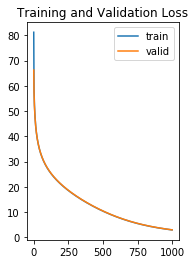

In [33]:
# 模型选择
# 通常使用K-Fold来选择模型并调节超参数
# 或者可以使用一些调参包

k, num_epoch, lr, weight_decay, batch_size = 5, 1000, 0.1, 0.2, 64
k_fold(k, train_features, train_labels, num_epoch,lr, weight_decay, batch_size)

In [ ]:
# 预测

x_train=tf.convert_to_tensor(train_features,dtype=tf.float32)
y_train=tf.convert_to_tensor(train_labels,dtype=tf.float32)
x_test=tf.convert_to_tensor(test_features,dtype=tf.float32)
model=tf.keras.models.Sequential([
  tf.keras.layers.Dense(1)
])
adam=tf.keras.optimizers.Adam(0.5)
model.compile(optimizer=adam,
              loss=tf.keras.losses.mean_squared_logarithmic_error
              )
model.fit(x_train, y_train, epochs=200,batch_size=32,verbose=0)
preds=np.array(model.predict(x_test))
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('submission.csv', index=False)